In [1]:
import utils
import json
import requests

# Get configuration
user1 = utils.getenvcached("QUETZALCOATL_USER1")
token1 = utils.getenvcached("QUETZALCOATL_TOKEN1")

uri = "http://127.0.0.1:5000/execute"

In [2]:
def qchem_query(q0, verb):
    q= {
        "__class__": "LongRangeChemistry",
        "user": user1,
        "token": token1,
        "query": q0,
        "op": verb        
    }
    qs = json.dumps(q)
    query = {      
        "user": user1,
        "token": token1,
        "query": qs,        
    } 
    post_response = requests.post(url = uri, json=query)
    rv = post_response.json()
    #print(rv)
    return rv

In [3]:
import time 

q0 = {
    "tag": "kr-h",
    "atom_list": ["Kr", "H"],
    "layers": 8,
    "patience": 10,
    "user": user1,
    "token": token1
}

rv0 = qchem_query(q0, "check_status")
print(rv0)

if rv0['status'] == 'running':
    rv1 = qchem_query(q0, "submit")
    print(rv1)

c = 0
while True:
    rv2 = qchem_query(q0, "check_status")
    if c % 60 == 0:
        print(rv2)
    if rv2['status'] != 'running': 
        break
    time.sleep(1.0)
    c += 1

results = qchem_query(q0, "results")
print(results)

{'status': 'running'}
{'status': 'submitted'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'status': 'running'}
{'angle_array': [[0.0, 0.17453292519943295, 0.3490658503988659, 0.5235987755982988, 0.6981317007977318, 0.8726646259971648, 1.0471975511965976, 1.2217304763960306, 1.3962634015954636, 1.5707963267948966], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], 'distance_array': [[0.1, 0.16938775510204082, 0.23877551020408164, 0.3081632653061225, 0.37755102040816324, 0.4469387755102041, 0.5163265306122449, 0.5857142857142857, 0.6551020408163265, 0.7244897959183673, 0.7938775510204081, 0.863265306122449, 0.9326530612244898, 1.002040816

In [4]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
from typing import Optional
import numpy as np
import os
from strawberryfields.backends.tfbackend.states import FockStateTF
from math import exp
from src.utils import von_neumann_entropy, renyi_entropy
from src.utils import quadratures_density, make_gif
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from matplotlib import ticker

2024-03-26 21:44:54.562711: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-26 21:44:54.584863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 21:44:54.584889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 21:44:54.585595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 21:44:54.589881: I tensorflow/core/platform/cpu_feature_guar

In [5]:
golden_mean = (np.sqrt(5.0)-1.0)/2.0

subplotlabelfont = {'fontweight': 'bold', 'fontsize': 9}

def format_axes(axes, position=(-.1, 1.02)):
    for i, ax in enumerate(axes, start=97):
        ax.text(*position, chr(i), fontdict=subplotlabelfont, weight='bold',
                transform=ax.transAxes)

def figsize(scale, aspect_ratio = golden_mean):
    fig_width_pt = 246.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch

    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*aspect_ratio              # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

rcparams = {                      # setup matplotlib to use latex for output
    "axes.labelsize": 12,               # LaTeX default is 10pt font.
    "axes.linewidth": 2,
    'lines.linewidth': 2,
    "xtick.major.width": 2,
    "ytick.major.width": 2,
    "lines.markersize":2,
    "font.size": 9,
    "legend.fontsize": 10,               # Make the legend/label fonts a little smaller
    "axes.spines.top": True,
    "axes.spines.right": True,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize(1.5),  
    "xtick.direction": "inout",
    "ytick.direction": "inout"# default fig size of 0.9 textwidth
    }

mpl.rcParams.update(rcparams)

dt=1e-3
steps=int(2e5)
x=np.array(list(range(0,steps)))*dt
a=1
a2=.4

### tick parameters
tick_dir = 'in' # out, inout
tick_len = 5
tick_width = 1

In [6]:
dir = '.' 
plots_path = os.path.join(dir + '/latex', 'figures')
os.makedirs(plots_path, exist_ok=True)
res = np.array(results['results'][0]) + 1j*np.array(results['results'][1])
starting_distance = 0

binding_energies = res[:, starting_distance:, -1, -1]
states = res[:, starting_distance:, :-1, :-1]
distances = np.array(results['distance_array'][0])[starting_distance:] + 1j*np.array(results['distance_array'][1])[starting_distance:] 
thetas = np.array(results['angle_array'][0])
quadrature_grid = np.array(results['quadrature_array'][0]) + 1j*np.array(results['quadrature_array'][1])
startingDistance = [1, 2, 3, 5, 7, 8, 10, 12, 15, 18, 24, 22, 18, 17, 17, 16, 21, 25, 24] 

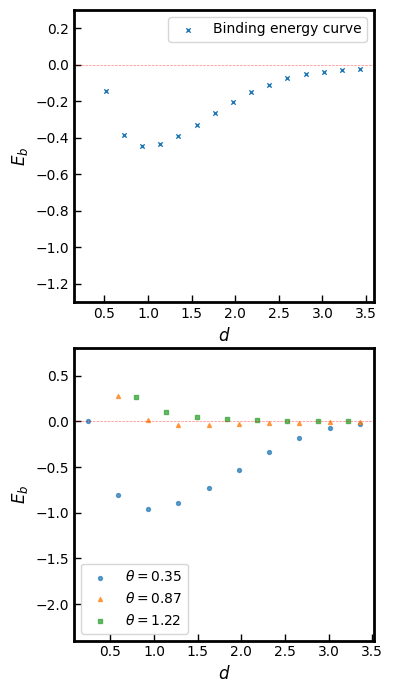

In [7]:
def plot_binding_curve(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    angle_idx: int,
    angles: list,
    ymin: Optional[float]=None,
    ymax: Optional[float]=None
) -> None:

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,7))
    line0 = axes[0].scatter(
        distance_array[startingDistance[angle_idx-1]::3], 
        binding_energy_array[angle_idx, startingDistance[angle_idx-1]::3], 
        s=10, 
        marker='x',
        alpha=1,
        label='Binding energy curve', 
        zorder=2,
        linewidths=1
    )

    axes[0].axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )
    
    axes[0].set_xlabel(r'$d$')
    axes[0].set_ylabel(r'$E_b$')
    axes[0].set_ylim(ymin[0], ymax[0])
    axes[0].grid(False)
    axes[0].legend(handles=[line0])
    axes[0].tick_params(direction=tick_dir, length=tick_len, width=tick_width)

    every = 5

    angle_idx0 = angles[0]
    line0 = axes[1].scatter(
        distance_array[startingDistance[angle_idx0-1]::every], 
        binding_energy_array[angle_idx0, startingDistance[angle_idx0-1]::every], 
        s=8, 
        marker='o',
        alpha=0.7,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx0]), 
        zorder=2,
        linewidths=1
    )
    
    angle_idx1 = angles[1]
    line1 = axes[1].scatter(
        distance_array[startingDistance[angle_idx1-1]::every], 
        binding_energy_array[angle_idx1, startingDistance[angle_idx1-1]::every], 
        s=8, 
        marker='^',
        alpha=0.7,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx1]),  
        zorder=2,
        linewidths=1
    )

    angle_idx2 = angles[2]
    line2 = axes[1].scatter(
        distance_array[startingDistance[angle_idx2-1]::every], 
        binding_energy_array[angle_idx2, startingDistance[angle_idx2-1]::every], 
        s=8, 
        marker='s',
        alpha=0.7,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx2]), 
        zorder=2,
        linewidths=1
    )

    axes[1].axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )
    
    axes[1].set_xlabel(r'$d$')
    axes[1].set_ylabel(r'$E_b$')
    axes[1].set_ylim(ymin[1], ymax[1])
    axes[1].grid(False)
    axes[1].legend(handles=[line0, line1, line2])
    axes[1].tick_params(direction=tick_dir, length=tick_len, width=tick_width)

    plt.tight_layout(h_pad=0.3)

    #plt.savefig(os.path.join(plots_path, 'ex_binding_3_figs.pdf'), dpi=300, transparent=False, bbox_inches='tight')
    #plt.savefig(os.path.join(plots_path, 'ex_binding_3_figs.png'), dpi=300, transparent=False, bbox_inches='tight')

plot_binding_curve(
    distance_array=distances,
    binding_energy_array=binding_energies,
    angles=[2, 5, 7], # 3,7,15
    ymin=[-1.3, -2.4], # ymin=[-0.55, -2.4],
    ymax=[0.3, 0.8], # [0.3, 0.8],
    angle_idx=3 # 7
)